# Generative Neural Network Exercise 1

Group Members: Ertugrul Taparci, Irmak Erkol, Umut Alperen Cengiz

## 1 Two-dimensional data

In [55]:
import numpy as np
from sklearn.datasets import make_moons
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [56]:
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

### 1. a two-dimensional histogram

In [94]:
class Histogram_2D:
    """
    In this function, we will try to select the appropriate bin width (h) and numbers (M)
    """
    def __init__(self):
        self.densities = None
        self.probabilities = None
        self.x_edges = None
        self.y_edges = None
        self.bin_areas = None
        self.xmin = None
        self.ymin = None
        self.xmax = None
        self.ymax = None
        self.h_x = None
        self.h_y = None
        self.M_x = None
        self.M_y = None
        
    def fit(self, X):
        N = X.shape[0] # total # of samples (N)
        if N == 0:
            raise ValueError("Data should not be empty!")
            
        print(f"Total samples N = {N}")
        # since we will work in tho axis: let's divide them
        x_data = X[:, 0]
        y_data = X[:, 1]
    
        # In this exercise; we will try to choose appropriate bin width (h) and number of bins (M). 
        # Since we have 2D histogram here: we need to find them for both axis: x and y
        
        # (1) Find xmin and ymin:
        self.xmin = x_data.min()
        self.ymin = y_data.min()
    
        print(f"X-Axis: min={self.xmin:.2f}, Y-Axis: mix={self.ymin:.2f}")
    
    
        # (2) Define h (bin width) using Interquartile Range (IQR):
        
        # To calculate h, we need interquantile range. h = 2*IQR / N^(1/3)
        q75_x, q25_x = np.percentile(x_data, [75, 25])
        iqr_x = q75_x - q25_x
        self.h_x = (2 * iqr_x) / (N**(1/3))
        print(f"X-Axis: h_x={self.h_x:.2f}")
    
        q75_y, q25_y = np.percentile(y_data, [75, 25])
        iqr_y = q75_y - q25_y
        self.h_y = (2 * iqr_y) / (N**(1/3))
        print(f"Y-Axis: h_y={self.h_y:.2f}")
        
    
        # (3) Define M (number of bins)
        # M is the smallest integer such that xmax <= xmin + M * h
        # We need xmax and ymax to calculate their M values
        self.xmax = x_data.max()
        self.ymax = y_data.max()
        print(f"X-Axis: max={self.xmax:.2f}, Y-Axis: max={self.ymax:.2f}")
        
        self.M_x = np.ceil((self.xmax - self.xmin) / self.h_x)
        self.M_y = np.ceil((self.ymax - self.ymin) / self.h_y)
            
        print(f"X-Axis: M_x = {self.M_x}")
        print(f"Y-Axis: M_y = {self.M_y}")
    
        
        # (4) Calculate density and/or probability (pk):
    
        # We need M+1 edges to define M bins. We need these because we need to identify the starting and ending points of each bins.
        # np.linspace() function will bring us the edges (borders of each bin)
        self.x_edges = np.linspace(
            self.xmin, # starting point
            self.xmin + self.M_x * self.h_x,  # this is to cover all area starting from min value of x
            int(self.M_x) + 1 # number of edges
        )
        
        self.y_edges = np.linspace(
            self.ymin, 
            self.ymin + self.M_y * self.h_y, 
            int(self.M_y) + 1
        )
    
        # Now, up to here, we obtain the grid with the appropriate size. 
        # It is time to calculate how many points from our data exist in each bin.
    
        # To calculate # of points in each bin, we will use np.histogram2d function. 
        # We will give x and y data and the borders (edges), it will return the # of points.
    
        counts, _, _ = np.histogram2d(
            x_data, y_data, bins=[self.x_edges, self.y_edges]
        )
        
        # We need to transpose it for the calculation (found after trial & error process [Tesing]):
        counts = counts.T
        
        # In 1-D Histogram, we have bin width(h). In 2-D histogram, we need Area of each bin.
    
        # we will use np.diff and np.outer here to calculate area:
        
        # np.diff finds the width of each bin:
        x_bin_widths = np.diff(self.x_edges)
        y_bin_widths = np.diff(self.y_edges)
        
        # np.outer gives the area (width * height) for each bin:
        self.bin_areas = np.outer(y_bin_widths, x_bin_widths)
    
        # Now we know Nk(counts), N(N), and h(area:self.bin_areas), we can calculate pk
        self.densities = counts / (N * self.bin_areas + 1e-12)
        
        # probability (without dividing by h:area):
        self.probabilities = counts / N
    
    def sample(self, n_samples):
            
        flat_probs = self.probabilities.flatten()
        total_prob = np.sum(flat_probs)
            
        normalized_probs = flat_probs / total_prob
            
        bin_indices_flat = np.random.choice(
            len(normalized_probs), 
            size=n_samples, 
            p=normalized_probs
        )
        
        i_indices, j_indices = np.unravel_index(
            bin_indices_flat, self.probabilities.shape
        )
        
        x_low = self.x_edges[j_indices]
        x_high = self.x_edges[j_indices + 1]
        
        y_low = self.y_edges[i_indices]
        y_high = self.y_edges[i_indices + 1]
        
        sampled_x = np.random.uniform(low=x_low, high=x_high, size=n_samples)
        sampled_y = np.random.uniform(low=y_low, high=y_high, size=n_samples)
        
        return np.stack([sampled_x, sampled_y], axis=1)

    def score_samples(self, X):
        x_indices = np.digitize(X[:, 0], self.x_edges)
        y_indices = np.digitize(X[:, 1], self.y_edges)
        
        scores = np.zeros(len(X))
        
        n_bins_y, n_bins_x = self.densities.shape
        
        is_inside = (x_indices > 0) & (x_indices <= n_bins_x) & \
                    (y_indices > 0) & (y_indices <= n_bins_y)
                    
        x_idx_inside = x_indices[is_inside] - 1
        y_idx_inside = y_indices[is_inside] - 1
        
        scores[is_inside] = self.densities[y_idx_inside, x_idx_inside]
        
        return scores

In [95]:
class SimpleHistogram2D:
    def __init__(self, bins=10):

        self.bins = bins
        self.probabilities = None
        self.densities = None
        self.x_edges = None
        self.y_edges = None
        self.bin_areas = None

    def fit(self, X):
        N = X.shape[0]

        counts, x_edges, y_edges = np.histogram2d(
            X[:, 0], X[:, 1], bins=self.bins
        )
        
        counts = counts.T
        self.x_edges = x_edges
        self.y_edges = y_edges
        
        x_bin_widths = np.diff(self.x_edges)
        y_bin_widths = np.diff(self.y_edges)
        
        self.bin_areas = np.outer(y_bin_widths, x_bin_widths)

        self.densities = counts / (N * self.bin_areas + 1e-12)
        self.probabilities = counts / N

    def sample(self, n_samples):
        flat_probs = self.probabilities.flatten()
        
        total_prob = np.sum(flat_probs)
        if total_prob == 0:
            return np.empty((0, 2))
            
        normalized_probs = flat_probs / total_prob
            
        bin_indices_flat = np.random.choice(
            len(normalized_probs), 
            size=n_samples, 
            p=normalized_probs
        )
        
        i_indices, j_indices = np.unravel_index(
            bin_indices_flat, self.probabilities.shape
        )
        
        x_low = self.x_edges[j_indices]
        x_high = self.x_edges[j_indices + 1]
        
        y_low = self.y_edges[i_indices]
        y_high = self.y_edges[i_indices + 1]
        
        sampled_x = np.random.uniform(low=x_low, high=x_high, size=n_samples)
        sampled_y = np.random.uniform(low=y_low, high=y_high, size=n_samples)
        
        return np.stack([sampled_x, sampled_y], axis=1)

    def score_samples(self, X): 
        x_indices = np.digitize(X[:, 0], self.x_edges)
        y_indices = np.digitize(X[:, 1], self.y_edges)
        
        scores = np.zeros(len(X))
        
        n_bins_y, n_bins_x = self.densities.shape
        
        is_inside = (x_indices > 0) & (x_indices <= n_bins_x) & \
                    (y_indices > 0) & (y_indices <= n_bins_y)
                    
        x_idx_inside = x_indices[is_inside] - 1
        y_idx_inside = y_indices[is_inside] - 1
        
        scores[is_inside] = self.densities[y_idx_inside, x_idx_inside]
        
        return scores

### 2. a single Gaussian

In [96]:
class SingleGaussian:
    
    def __init__(self):
        self.mean = None 
        self.cov = None  

    def fit(self, X):
        N, D = X.shape
        
        self.mean = np.mean(X, axis=0) 
        self.cov = np.cov(X, rowvar=False, bias=True)

    def sample(self, n_samples):
        return np.random.multivariate_normal(
            self.mean, 
            self.cov, 
            size=n_samples
        )

    def score_samples(self, X):
        # we need to calculate the probability density of the new point X    
        return multivariate_normal.pdf(
            X, 
            mean=self.mean, 
            cov=self.cov
        )

### 3. a Gaussian mixture model (GMM)

In [97]:
class GaussianMixtureModel:

    def __init__(self, n_components, n_iter=100, tol=1e-6, reg_cov=1e-6):
        self.n_components = n_components
        self.n_iter = n_iter
        self.tol = tol
        self.reg_cov = reg_cov
        
        self.weights = None
        self.means = None
        self.covs = None
        self.log_likelihood = -np.inf

    def fit(self, X):
        N, D = X.shape
        
        self.weights = np.ones(self.n_components) / self.n_components
        
        indices = np.random.choice(N, self.n_components, replace=False)
        self.means = X[indices]
        
        self.covs = np.array([np.eye(D) for _ in range(self.n_components)])
        
        for i in range(self.n_iter):

            # Learning by EM algorithm:
            # E-step
            responsibilities = self._e_step(X)
            
            # M-step
            self._m_step(X, responsibilities)
            
            # Checking for convergence:
            log_likelihood = self.score_samples(X)
            if np.abs(np.mean(log_likelihood) - self.log_likelihood) < self.tol:
                break
            self.log_likelihood = np.mean(log_likelihood)

    def _e_step(self, X):
        # Expectation Step:
        weighted_log_probs = np.zeros((X.shape[0], self.n_components))
        
        for k in range(self.n_components):
            weighted_log_probs[:, k] = np.log(self.weights[k]) + \
                multivariate_normal.logpdf(X, self.means[k], self.covs[k])
            
        log_prob_norm = np.log(np.sum(np.exp(weighted_log_probs), axis=1))
        
        responsibilities = np.exp(weighted_log_probs - log_prob_norm[:, np.newaxis])
        return responsibilities

    def _m_step(self, X, responsibilities):
        # Maximization step:
        N, D = X.shape
        
        nk = np.sum(responsibilities, axis=0)
        
        self.weights = nk / N
        
        self.means = np.dot(responsibilities.T, X) / nk[:, np.newaxis]
        
        for k in range(self.n_components):
            diff = X - self.means[k]
            cov_k = np.dot((responsibilities[:, k] * diff.T), diff) / nk[k]
            cov_k.flat[::D+1] += self.reg_cov
            self.covs[k] = cov_k

    def sample(self, n_samples):            
        component_choices = np.random.choice(
            self.n_components, 
            size=n_samples, 
            p=self.weights
        )
        
        samples = np.zeros((n_samples, self.means.shape[1]))
        for k in range(self.n_components):
            mask = (component_choices == k)
            n_k = np.sum(mask)
            if n_k > 0:
                samples[mask] = np.random.multivariate_normal(
                    self.means[k], 
                    self.covs[k], 
                    size=n_k
                )
        return samples

    def score_samples(self, X):
        log_probs = np.zeros((X.shape[0], self.n_components))
        
        for k in range(self.n_components):
            log_probs[:, k] = np.log(self.weights[k]) + \
                multivariate_normal.logpdf(X, self.means[k], self.covs[k])
                
        log_prob = np.log(np.sum(np.exp(log_probs), axis=1))
        return np.exp(log_prob)

### 4. a kernel density estimator (KDE)

In [98]:
class KernelDensityEstimator:

    def __init__(self, bandwidth=0.2):
        self.bandwidth = bandwidth
        self.train_data = None
        self.N = 0
        self.cov = None
        self.D = 0

    def fit(self, X):
        self.train_data = X
        self.N, self.D = X.shape
        
        self.cov = np.eye(self.D) * (self.bandwidth**2)

    def sample(self, n_samples):
        indices = np.random.choice(self.N, size=n_samples, replace=True)
        
        base_samples = self.train_data[indices]
        
        noise = np.random.multivariate_normal(
            np.zeros(self.D), 
            self.cov, 
            size=n_samples
        )
        
        return base_samples + noise

    def score_samples(self, X):            
        n_test = X.shape[0]
        densities = np.zeros(n_test)
        
        for i in range(self.N):
            densities += multivariate_normal.pdf(
                X, 
                mean=self.train_data[i], 
                cov=self.cov
            )
            
        return densities / self.N

### $MMD^2$ Calculation

We know the following formula:
$$
\text{MMD}^2(X, Y) = \frac{1}{n(n-1)}\sum_{i \neq j} k(x_i, x_j) + \frac{1}{m(m-1)}\sum_{i \neq j} k(y_i, y_j) - \frac{2}{nm}\sum_{i=1}^{n}\sum_{j=1}^{m} k(x_i, y_j)
$$

Squared Exponential (SE) Kernel:

$$
se(x, x') = \exp\left(-\frac{||x - x'||^2}{h^2}\right)
$$

Inverse Multi-Quadratic (IMQ) Kernel:

$$
imq(x, x') = \frac{1}{\sqrt{1 + ||x - x'||^2}}
$$

In [99]:
def se_kernel(X, Y, h=1.0):
    sqdist = cdist(X, Y, 'sqeuclidean')
    
    return np.exp(-sqdist / (h**2))

def imq_kernel(X, Y, h=None):
    sqdist = cdist(X, Y, 'sqeuclidean')
    
    return 1.0 / np.sqrt(1.0 + sqdist)

def mmd2(X, Y, kernel, h=1.0):
    n, d = X.shape
    m, _ = Y.shape

    # 1. Compute the kernel matrices
    K_xx = kernel(X, X, h)
    K_yy = kernel(Y, Y, h)
    K_xy = kernel(X, Y, h)
    
    # 2. Compute the three MMD2 terms
    
    # Term 1: E[k(x, x')]
    # sum over i != j
    term_xx = (np.sum(K_xx) - np.trace(K_xx)) / (n * (n - 1))
    
    # Term 2: E[k(y, y')]
    term_yy = (np.sum(K_yy) - np.trace(K_yy)) / (m * (m - 1))
    
    # Term 3: -2 * E[k(x, y)]
    # (np.sum(K_xy) * 2) / (n * m)
    term_xy = np.mean(K_xy) * 2
    
    return term_xx + term_yy - term_xy

### Tests

#### Let's see accuracy of our model:

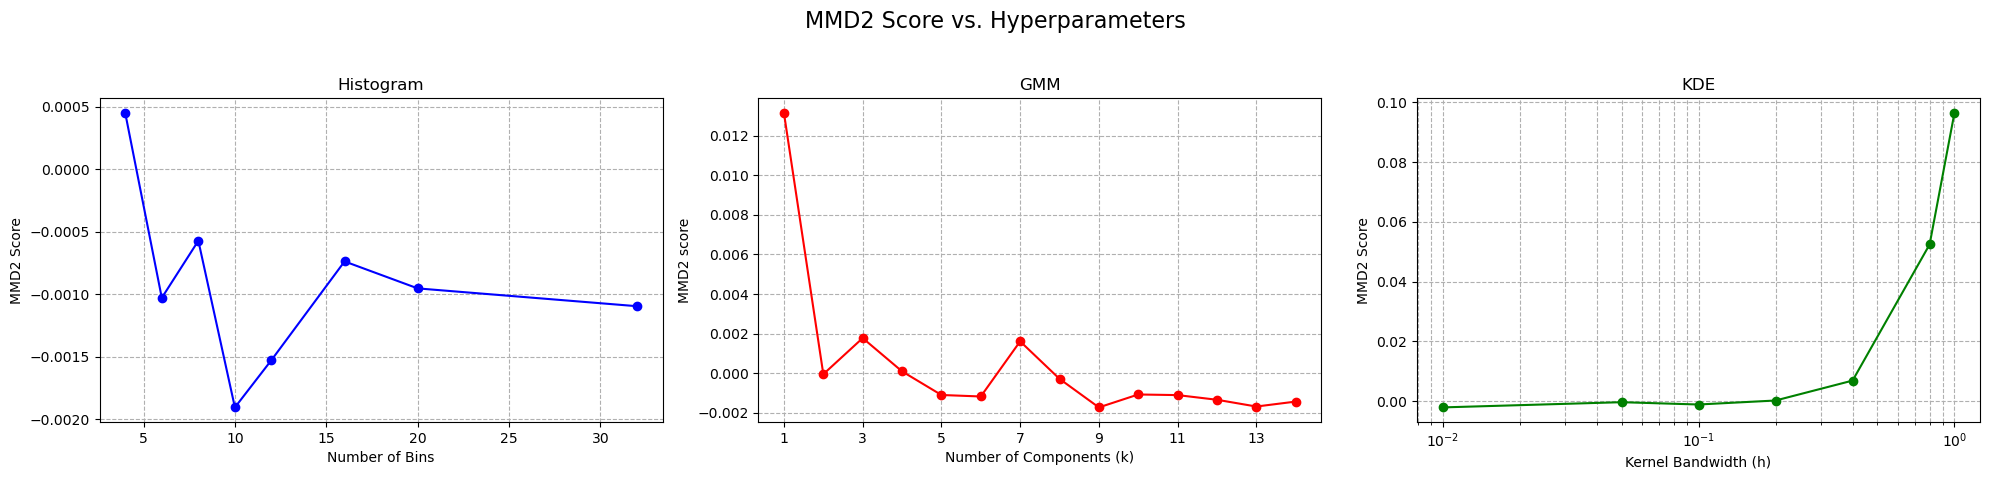

In [101]:
# TS creation:
X_train, _ = make_moons(n_samples=500, noise=0.1, random_state=42)

# another sets for comparison:
X_test, _ = make_moons(n_samples=500, noise=0.1, random_state=123)

# hyperparameters:
gmm_components = list(range(1, 15))
kde_bandwidths = [0.01, 0.05, 0.1, 0.2, 0.4, 0.8, 1.0]
hist_bins = [4, 6, 8, 10, 12, 16, 20, 32]

# MMD2 scores will be stored in the following lists:
gmm_scores = []
kde_scores = []
hist_scores = []

# GNN evaluation:
for k in gmm_components:
    model = GaussianMixtureModel(n_components=k)
    model.fit(X_train)
    X_generated = model.sample(n_samples=500)
    
    # Use the 'se_kernel' with h=1.0 for this example
    score = mmd2(X_test, X_generated, kernel=se_kernel, h=1.0)
    gmm_scores.append(score)

# KDR evaluation:
for h in kde_bandwidths:
    model = KernelDensityEstimator(bandwidth=h)
    model.fit(X_train)
    X_generated = model.sample(n_samples=500)
    
    score = mmd2(X_test, X_generated, kernel=se_kernel, h=1.0)
    kde_scores.append(score)

# Histogram Evaluation:
for b in hist_bins:
    model = SimpleHistogram2D(bins=b)
    model.fit(X_train)
    X_generated = model.sample(n_samples=500)
    
    score = mmd2(X_test, X_generated, kernel=se_kernel, h=1.0)
    hist_scores.append(score)

# Let's see the results:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("MMD2 Score vs. Hyperparameters", fontsize=16)

# Histogram Plot
axes[0].plot(hist_bins, hist_scores, 'bo-')
axes[0].set_title("Histogram")
axes[0].set_xlabel("Number of Bins")
axes[0].set_ylabel("MMD2 Score")
axes[0].grid(True, ls='--')

# GMM Plot
axes[1].plot(gmm_components, gmm_scores, 'ro-')
axes[1].set_title("GMM")
axes[1].set_xlabel("Number of Components (k)")
axes[1].set_ylabel("MMD2 score")
axes[1].set_xticks(gmm_components[::2]) # Show every other tick
axes[1].grid(True, ls='--')

# KDE Plot
axes[2].plot(kde_bandwidths, kde_scores, 'go-')
axes[2].set_title("KDE")
axes[2].set_xlabel("Kernel Bandwidth (h)")
axes[2].set_ylabel("MMD2 Score")
axes[2].set_xscale('log') # Bandwidths are exponential
axes[2].grid(True, which="both", ls='--')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Comments

--**Hist**: When we have 10 or 32 bins, model brings the best result.<br>
--**KDE**: For small bandwidths, model achieves good results (low scores). When bandwidth is too high, model will not distinct two moons and create one blob. <br>
--**GMM**: As we already know that, one component GMM gives the same result with single Gaussian. This is nearly 0.013, high MMD2 score. This means it is a bad model. When it has 4 components, we see a very bad local minima due to randomness. When we have 7 or 9 components, we have a better model!

#### Accuracy vs TS size:

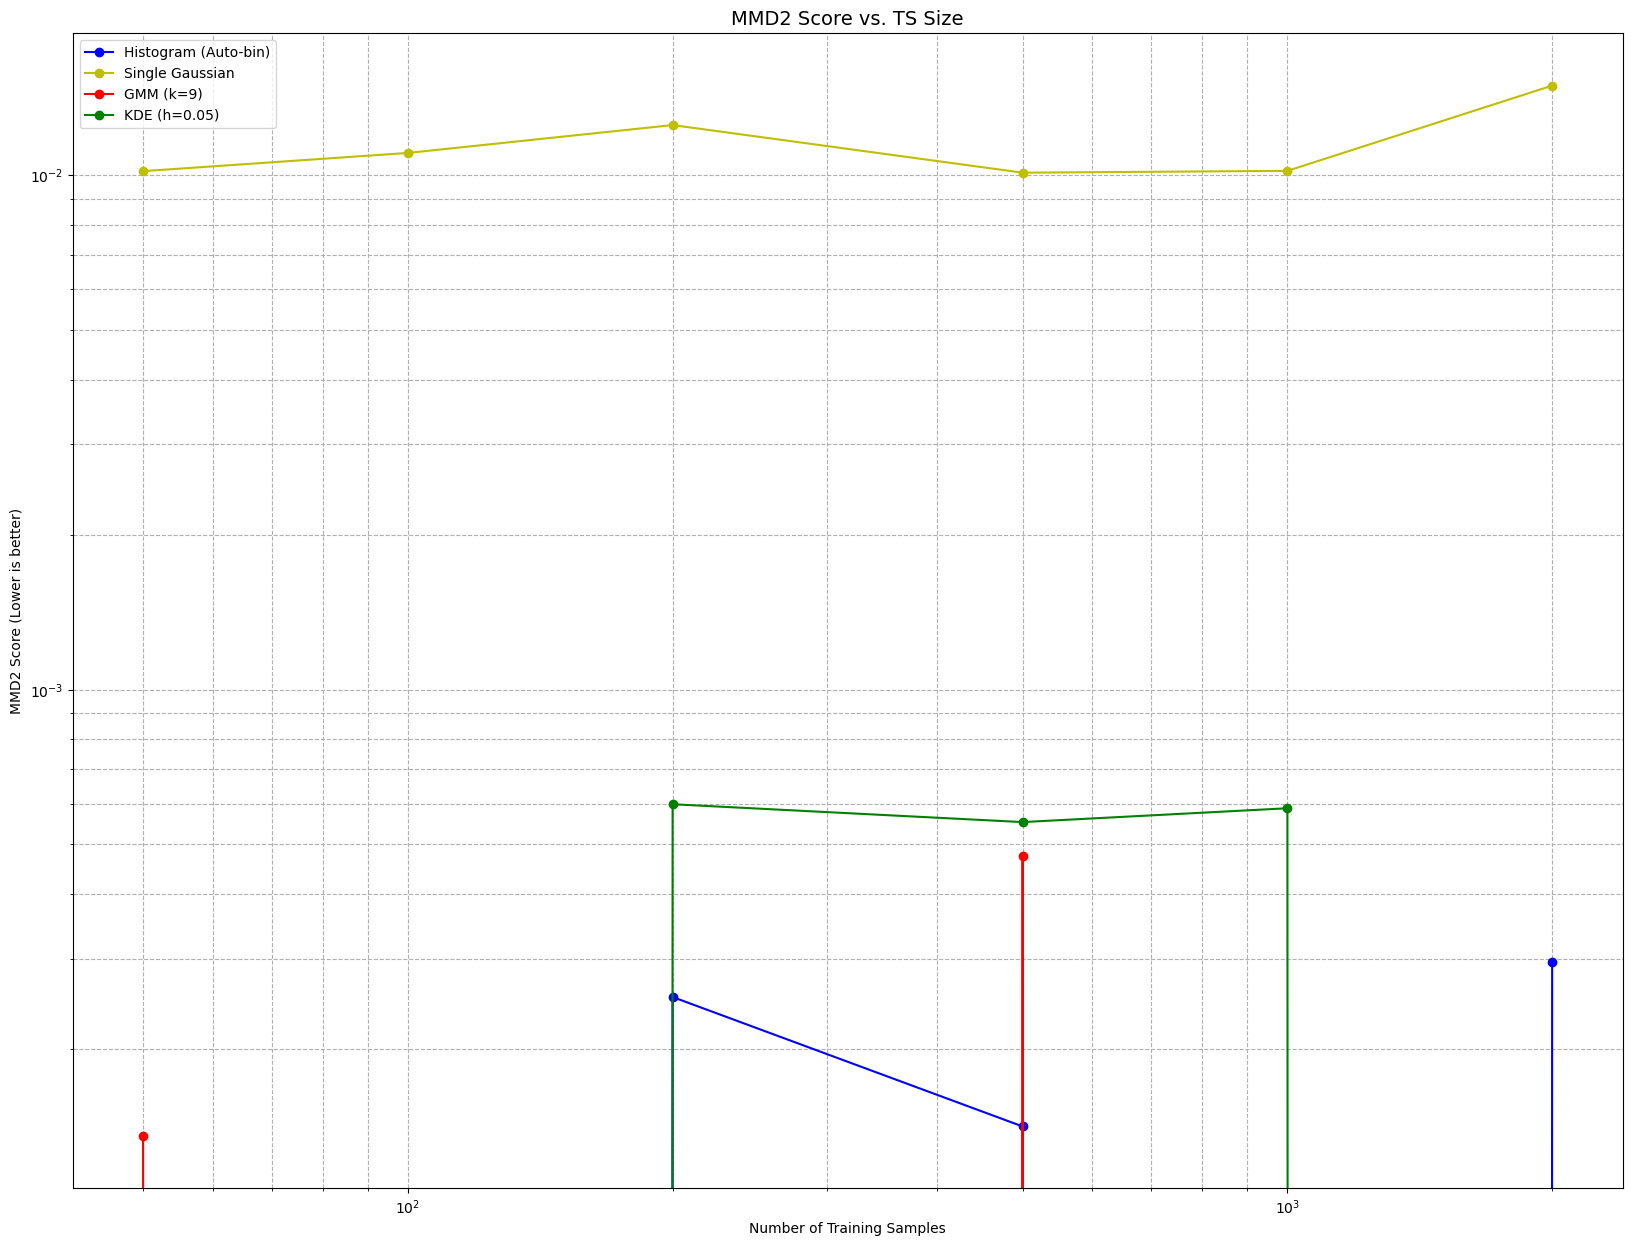

In [93]:
TS_size = [50, 100, 200, 500, 1000, 2000]

# text set:
X_test, _ = make_moons(n_samples=1000, noise=0.1, random_state=123)

# scores for each model:
hist_scores = []
sg_scores = []
gmm_scores = []
kde_scores = []

# Let's see them for each TS size:
for N_train in TS_size:
    
    # TS:
    X_train, _ = make_moons(n_samples=N_train, noise=0.1, random_state=42)
    
    # Histogram:
    model_hist = SimpleHistogram2D(bins=32)
    model_hist.fit(X_train)
    X_gen_hist = model_hist.sample(n_samples=1000)
    hist_scores.append(mmd2(X_test, X_gen_hist, kernel=se_kernel, h=1.0))
    
    # Single Gaussian:
    model_sg = SingleGaussian()
    model_sg.fit(X_train)
    X_gen_sg = model_sg.sample(n_samples=1000)
    sg_scores.append(mmd2(X_test, X_gen_sg, kernel=se_kernel, h=1.0))
    
    # GMM:
    model_gmm = GaussianMixtureModel(n_components=9)
    model_gmm.fit(X_train)
    X_gen_gmm = model_gmm.sample(n_samples=1000)
    gmm_scores.append(mmd2(X_test, X_gen_gmm, kernel=se_kernel, h=1.0))
    
    # KDE (best bandwidth is 0.05 from prev. exe.):
    model_kde = KernelDensityEstimator(bandwidth=0.05)
    model_kde.fit(X_train)
    X_gen_kde = model_kde.sample(n_samples=1000)
    kde_scores.append(mmd2(X_test, X_gen_kde, kernel=se_kernel, h=1.0))

# PLOT
plt.figure(figsize=(20, 15))
plt.title("MMD2 Score vs. TS Size", fontsize=14)

plt.plot(TS_size, hist_scores, 'bo-', label="Histogram (Auto-bin)")
plt.plot(TS_size, sg_scores, 'yo-', label="Single Gaussian")
plt.plot(TS_size, gmm_scores, 'ro-', label="GMM (k=9)")
plt.plot(TS_size, kde_scores, 'go-', label="KDE (h=0.05)")

plt.xlabel("Number of Training Samples")
plt.ylabel("MMD2 Score (Lower is better)")
plt.legend()
plt.xscale('log') # Use log scale for x-axis
plt.yscale('log') # Use log scale for y-axis
plt.grid(True, which="both", ls="--")
plt.show()

#### Comments:

We could see the entire graph for some of them. This is because, we could have "division by zero issue" in the model!

#### Good vs Bad Model Visualization:

In [102]:
def plot_model(model, X_train, title="Model"):
    # Fit the model
    model.fit(X_train)
    
    # Generate new samples
    X_generated = model.sample(n_samples=500)
    
    # plot:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title, fontsize=16)

    ax = axes[0]
    ax.set_title("Learned Density")

    # Grid:
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    x_grid = np.linspace(x_min, x_max, 100)
    y_grid = np.linspace(y_min, y_max, 100)
    XX, YY = np.meshgrid(x_grid, y_grid)
    points_on_grid = np.stack([XX.ravel(), YY.ravel()], axis=1)

    # Get the density score for every single points:
    Z = model.score_samples(points_on_grid)
    Z = Z.reshape(XX.shape)

    # Contour plot of the density:
    cf = ax.contourf(XX, YY, Z, levels=20, cmap='viridis')
    plt.colorbar(cf, ax=ax, label='Density')
    
    # Training data plot:
    ax.scatter(X_train[:, 0], X_train[:, 1], s=5, c='red', alpha=0.3, label='Training Data')
    ax.legend()
    ax.axis('equal')

    # Generated data plot:
    ax = axes[1]
    ax.set_title("Generated Samples")

    # Plot the generated samples
    ax.scatter(X_generated[:, 0], X_generated[:, 1], s=5, c='yellow', alpha=0.7, label='Generated Data')
    
    # Plot the training data as well
    ax.scatter(X_train[:, 0], X_train[:, 1], s=5, c='red', alpha=0.7, label='Training Data')
    ax.legend()
    ax.axis('equal')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#### Good Models:

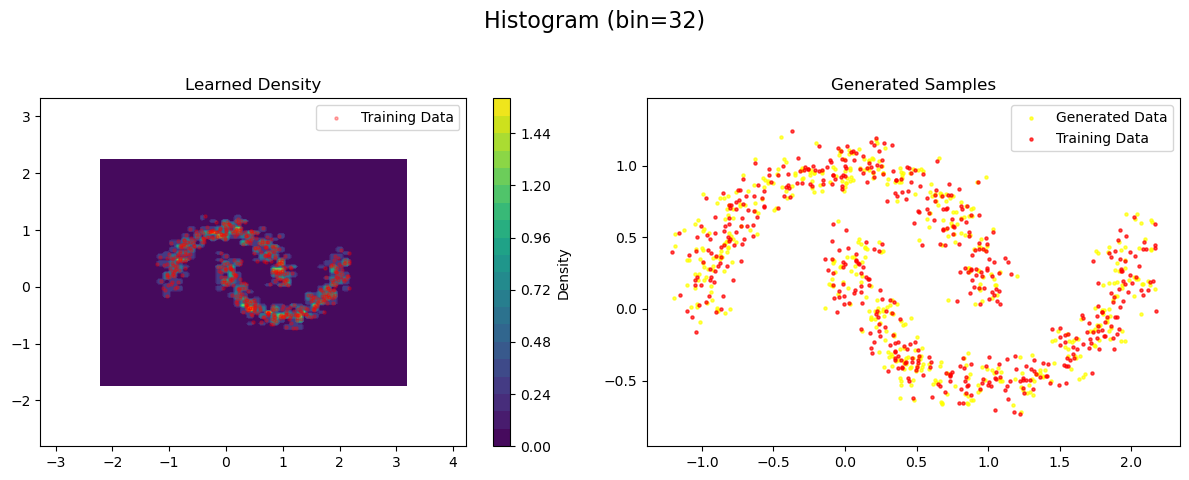

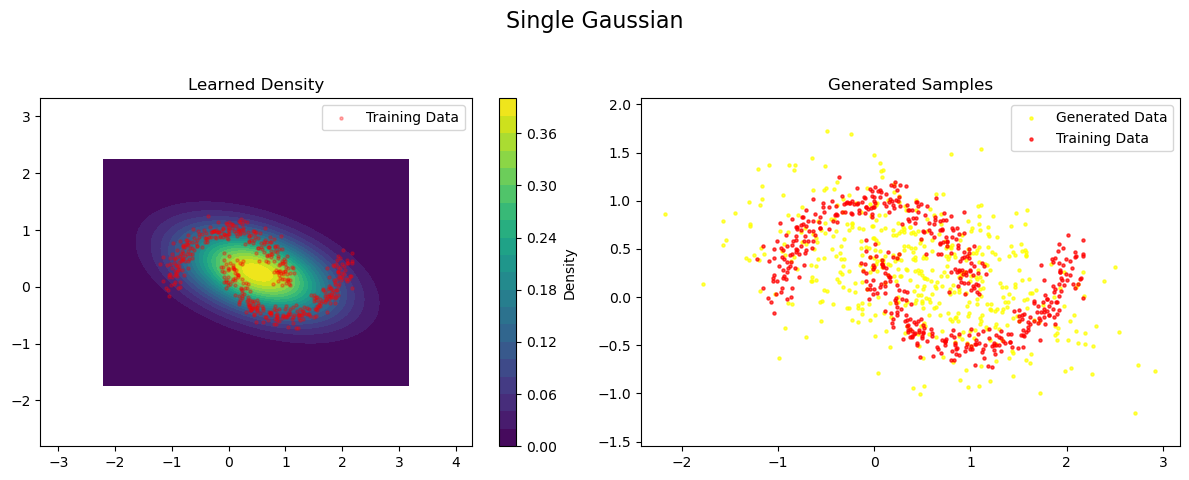

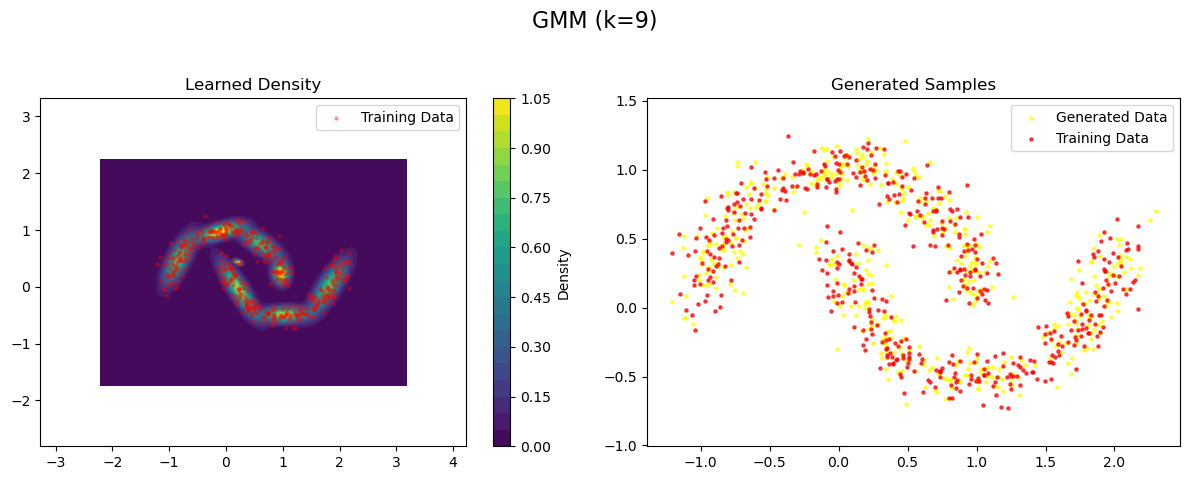

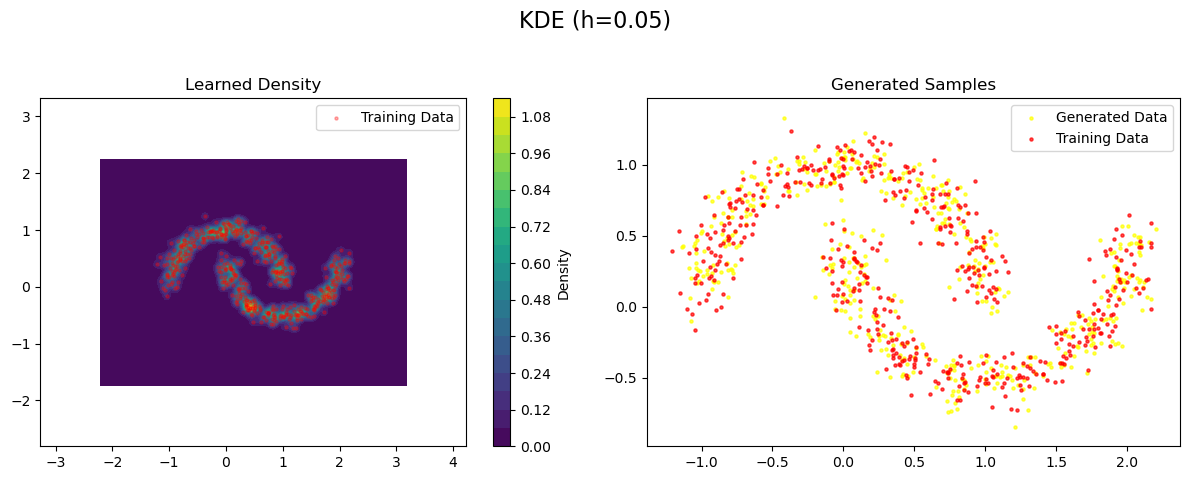

In [103]:
# Let's apply all model and see them in a visual 
X_train_final, _ = make_moons(n_samples=500, noise=0.1, random_state=42)

# 1. The Histogram model
hist2D_model = SimpleHistogram2D(bins=32)
plot_model(hist2D_model, X_train_final, title="Histogram (bin=32)")

# 2. A "bad" model (Single Gaussian)
sg_model = SingleGaussian()
plot_model(sg_model, X_train_final, title="Single Gaussian")

# 3. A "good" model (GMM with k=9)
gmm_model = GaussianMixtureModel(n_components=9)
plot_model(gmm_model, X_train_final, title="GMM (k=9)")

# 4. Another "good" model (KDE with h=0.05)
kde_model = KernelDensityEstimator(bandwidth=0.05)
plot_model(kde_model, X_train_final, title="KDE (h=0.05)")

#### Comments

- As you can see above, Single Gaussian is not able to detect two different moon in the dataset. That is the same result with GMM with one component.
- GMM and KDE brought the better results compared to histogram!

#### Bad Models

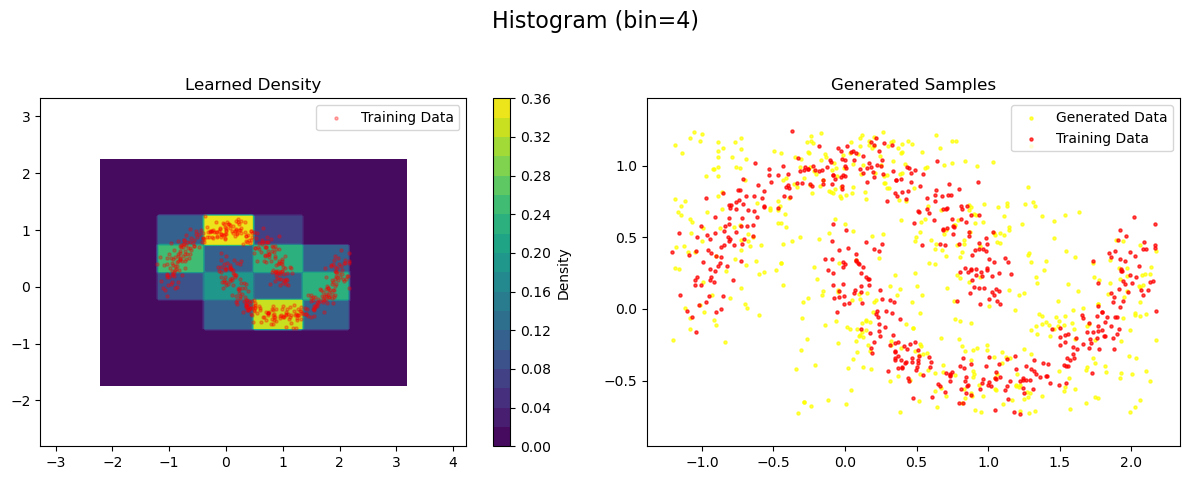

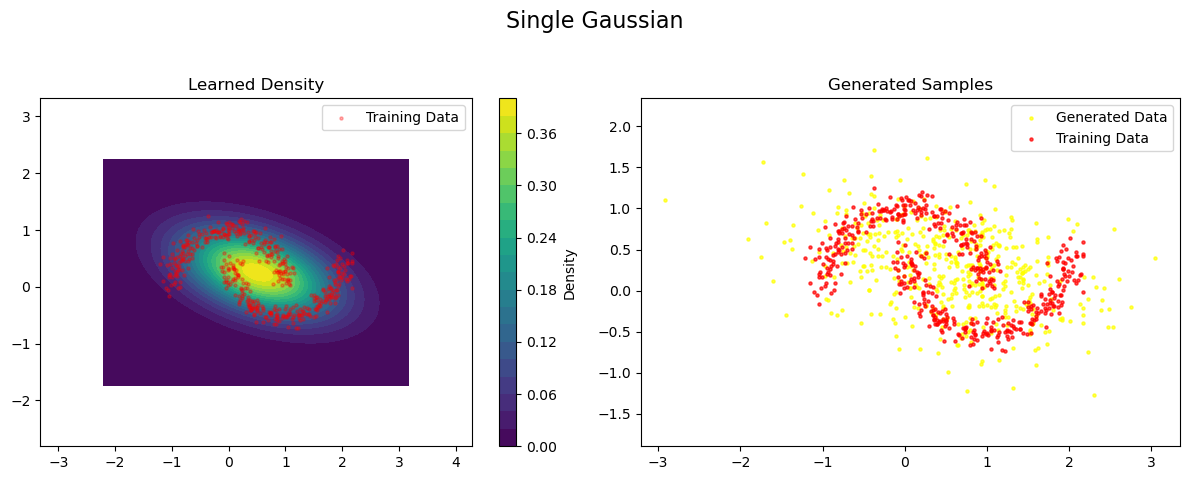

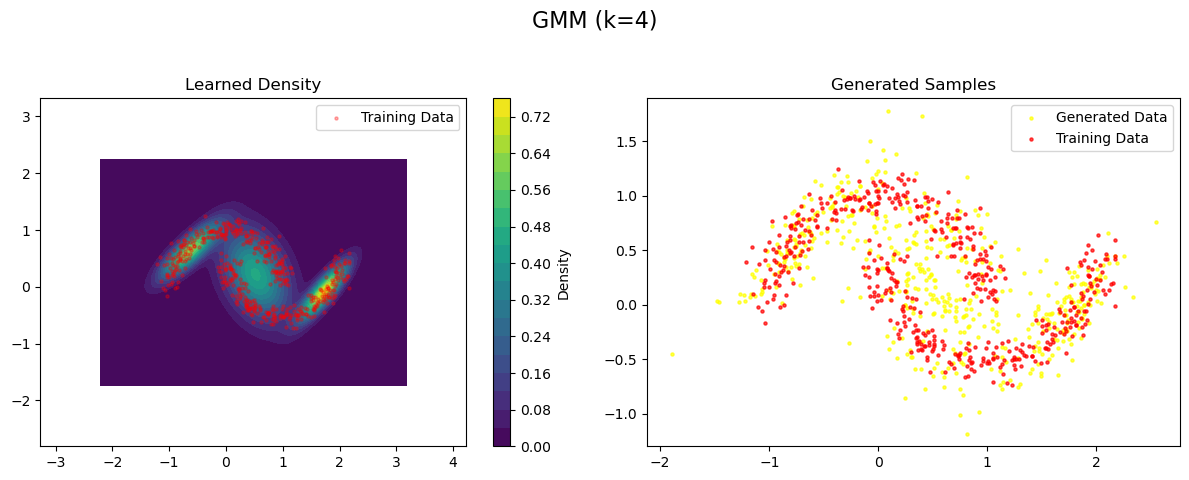

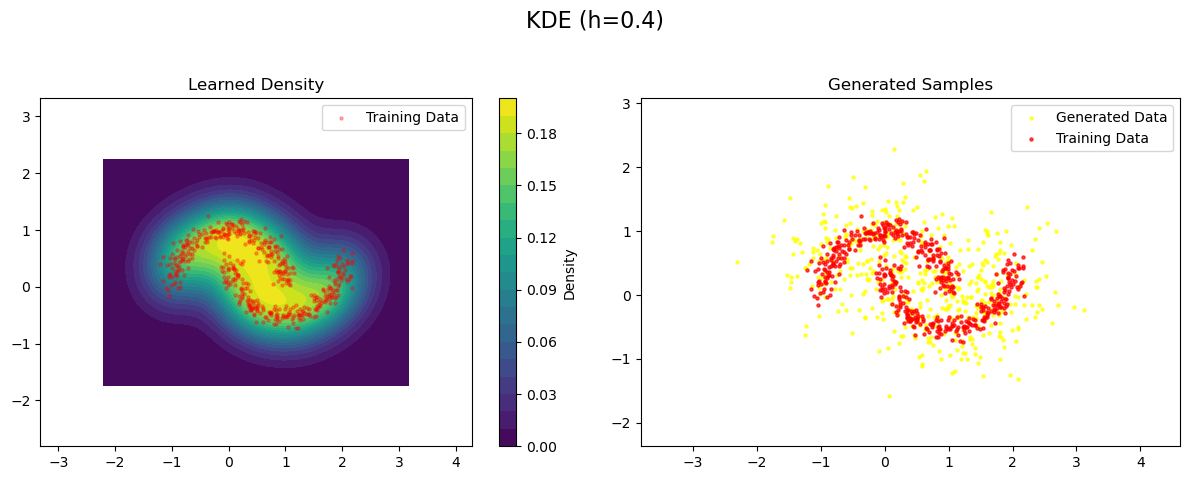

In [104]:
# Let's apply all model and see them in a visual 
X_train_final, _ = make_moons(n_samples=500, noise=0.1, random_state=42)

# 1. The Histogram model
hist2D_model = SimpleHistogram2D(bins=4)
plot_model(hist2D_model, X_train_final, title="Histogram (bin=4)")

# 2. A "bad" model (Single Gaussian)
sg_model = SingleGaussian()
plot_model(sg_model, X_train_final, title="Single Gaussian")

# 3. A "good" model (GMM with k=4)
gmm_model = GaussianMixtureModel(n_components=4)
plot_model(gmm_model, X_train_final, title="GMM (k=4)")

# 4. Another "good" model (KDE with h=0.4)
kde_model = KernelDensityEstimator(bandwidth=0.4)
plot_model(kde_model, X_train_final, title="KDE (h=0.4)")

#### Comments

It can be directly understood that, these models are worse cases. Learned Density maps show that during the surve of moon, model cannot detect that there should be data around the curves. For example, in KDE graph, data is located in the middle (yellow area)!

## 2 Higher-dimensional data

In [118]:
from sklearn.datasets import load_digits
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

In [119]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, DensityMixin

# The following code is adapted by the given website with the help of LLM!
class DensityForest(BaseEstimator, DensityMixin):
    
    def __init__(self, n_estimators=100, max_depth=None, bandwidth=1.0, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.bandwidth = bandwidth
        self.random_state = random_state
        
        # Internal model
        self.rf = RandomForestRegressor(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            random_state=self.random_state,
            n_jobs=-1  # Use all available cores
        )
        # Store data for sampling
        self.X_train_ = None

    def fit(self, X, y=None):
        kde = KernelDensity(bandwidth=self.bandwidth)
        kde.fit(X)
        
        # We use log_density for better numerical stability
        log_density_targets = kde.score_samples(X)
        
        self.rf.fit(X, log_density_targets)
        self.X_train_ = X
        return self

    def score_samples(self, X):
        # predict the log-density using the trained forest
        return self.rf.predict(X)

    def sample(self, n_samples=1):    
        n_features = self.X_train_.shape[1]
        
        # pick random points from the training data
        indices = np.random.choice(len(self.X_train_), n_samples, replace=True)
        samples = self.X_train_[indices]
        
        # add small Gaussian noise
        noise_std = np.std(self.X_train_) / np.sqrt(n_features)
        noise = np.random.normal(scale=noise_std, size=(n_samples, n_features))
        
        return samples + noise

In [120]:
# Load the data
digits = load_digits()
X_digits, y_digits = digits.data, digits.target

# Normalize the data (scale the data between 0-1
X_digits_scaled = X_digits / 16.0

# Split into a "real" training set and a "real" test set
X_train, X_test, y_train, y_test = train_test_split(
    X_digits_scaled, y_digits, 
    test_size=0.3, 
    random_state=42
)

C:\Users\ertug\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\ertug\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\ertug\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\ertug\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

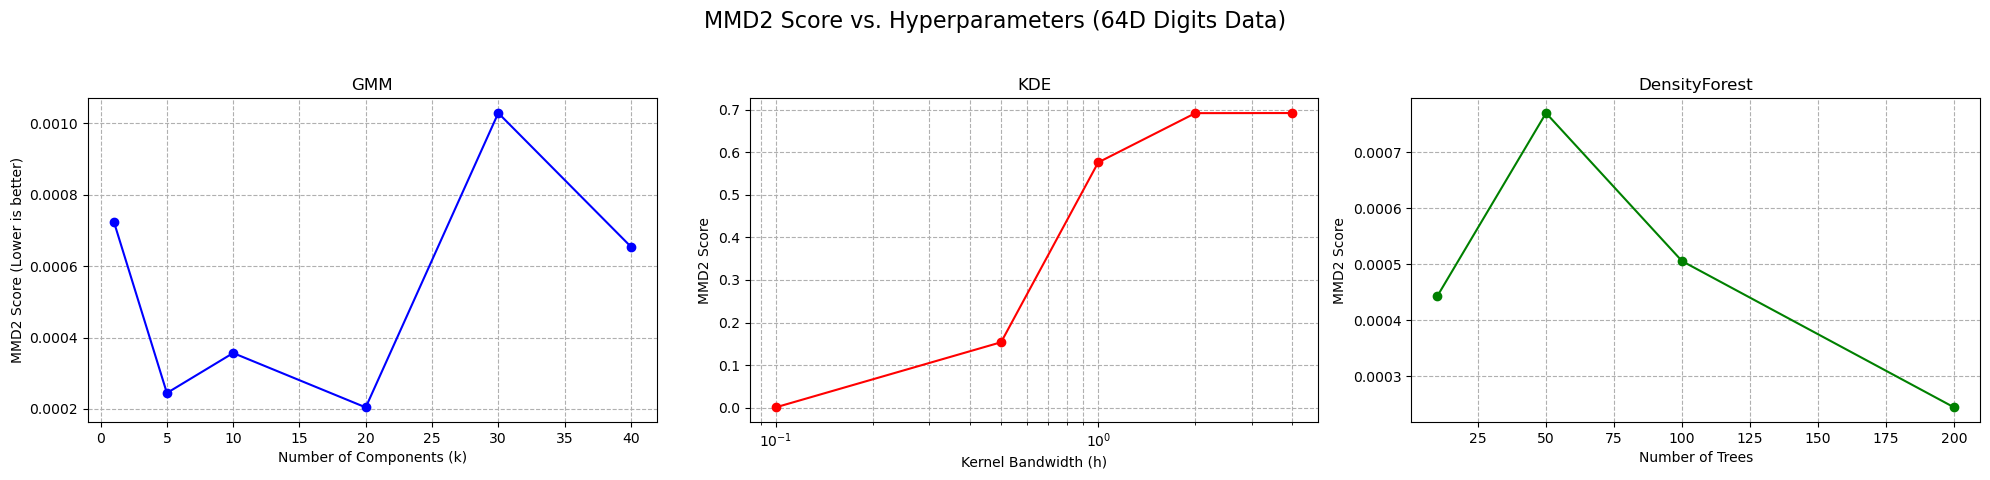

In [141]:
MMD_KERNEL_H = 5.0 # we will use a larger kernel badwidth for stability

# Hyperparameters:
gmm_components = [1, 5, 10, 20, 30, 40]
kde_bandwidths = [0.1, 0.5, 1.0, 2.0, 4.0]
forest_n_estimators = [10, 50, 100, 200]

# MMD2 scores list:
gmm_scores_64d = []
kde_scores_64d = []
forest_scores_64d = []

# GMM:
for k in gmm_components:
    model = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    model.fit(X_train)
    X_generated, _ = model.sample(n_samples=X_test.shape[0])
    
    score = mmd2(X_test, X_generated, kernel=se_kernel, h=MMD_KERNEL_H)
    gmm_scores_64d.append(score)

# KDE:
for h in kde_bandwidths:
    model = KernelDensity(bandwidth=h)
    model.fit(X_train)
    X_generated = model.sample(n_samples=X_test.shape[0])
    
    score = mmd2(X_test, X_generated, kernel=se_kernel, h=MMD_KERNEL_H)
    kde_scores_64d.append(score)

# DensityForest:
for n in forest_n_estimators:
    model = DensityForest(n_estimators=n, bandwidth=1.0, random_state=42)
    model.fit(X_train)
    X_generated = model.sample(n_samples=X_test.shape[0])
    
    score = mmd2(X_test, X_generated, kernel=se_kernel, h=MMD_KERNEL_H)
    forest_scores_64d.append(score)

# PLOT:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("MMD2 Score vs. Hyperparameters (64D Digits Data)", fontsize=16)

# GMM Plot
axes[0].plot(gmm_components, gmm_scores_64d, 'bo-')
axes[0].set_title("GMM")
axes[0].set_xlabel("Number of Components (k)")
axes[0].set_ylabel("MMD2 Score (Lower is better)")
axes[0].grid(True, ls='--')

# KDE Plot
axes[1].plot(kde_bandwidths, kde_scores_64d, 'ro-')
axes[1].set_title("KDE")
axes[1].set_xlabel("Kernel Bandwidth (h)")
axes[1].set_ylabel("MMD2 Score")
axes[1].set_xscale('log')
axes[1].grid(True, which="both", ls='--')

# DensityForest Plot
axes[2].plot(forest_n_estimators, forest_scores_64d, 'go-')
axes[2].set_title("DensityForest")
axes[2].set_xlabel("Number of Trees")
axes[2].set_ylabel("MMD2 Score")
axes[2].grid(True, ls='--')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- GMM: When number of components equal to 20, we have low MMD2. The model should give the better result!
- KDE: h=$10^{-3}$ will bring a better model!
- Density Forest: We should have 200 trees to obtain better model!

In [142]:
# We can use the full (scaled) dataset for training
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X_digits_scaled, y_digits, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_digits
)

# 1. Initialize the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train on the real data
classifier.fit(X_cls_train, y_cls_train)

# 3. Check its accuracy on a held-out test set of real data
accuracy = classifier.score(X_cls_test, y_cls_test)

print(f"Accuracy on test data: {accuracy * 100:.2f}%")

Accuracy on test data: 96.67%


In [144]:
def plot_generated_digits_and_classify(model, classifier, title="Model"):
    
    if isinstance(model, GaussianMixture):
        X_gen, _ = model.sample(n_samples=100)
    else:
        X_gen = model.sample(n_samples=100)
    
    # Visualize:
    fig_digits, axes = plt.subplots(10, 10, figsize=(8, 8),
                                    subplot_kw={'xticks':[], 'yticks':[]},
                                    gridspec_kw=dict(hspace=0.1, wspace=0.1))
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(X_gen[i].reshape(8, 8), cmap='binary')
        
    fig_digits.suptitle(f"Generated Digits: {title}", fontsize=16)
    plt.show()

    # Classification of generated digit:
    y_pred = classifier.predict(X_gen)
    
    # Plot histogram of predicted classes:
    fig_hist, ax = plt.subplots(figsize=(10, 4))
    ax.hist(y_pred, bins=np.arange(11) - 0.5, rwidth=0.8, align='mid')
    ax.set_title(f"Predicted Class Distribution for Generated Digits: {title}")
    ax.set_xlabel("Predicted Digit Class")
    ax.set_ylabel("Frequency")
    ax.set_xticks(range(10))
    plt.show()

C:\Users\ertug\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


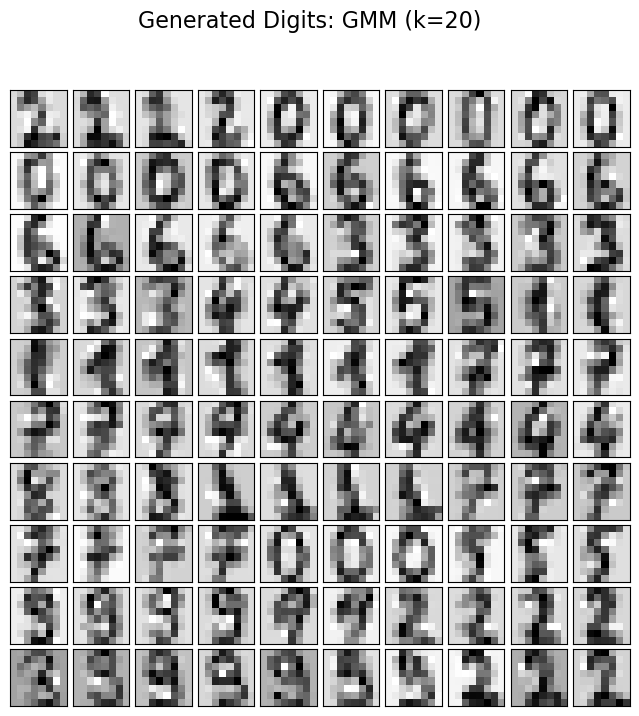

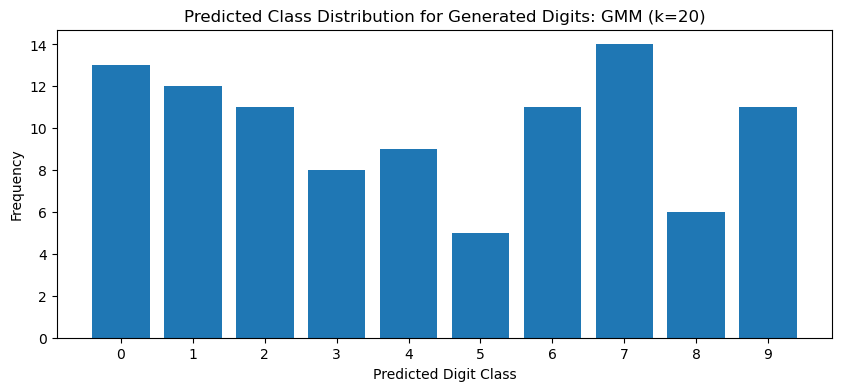

In [145]:
model_gmm_64d = GaussianMixture(n_components=20, covariance_type='full', random_state=42)
model_gmm_64d.fit(X_train)
plot_generated_digits_and_classify(model_gmm_64d, classifier, title="GMM (k=20)")

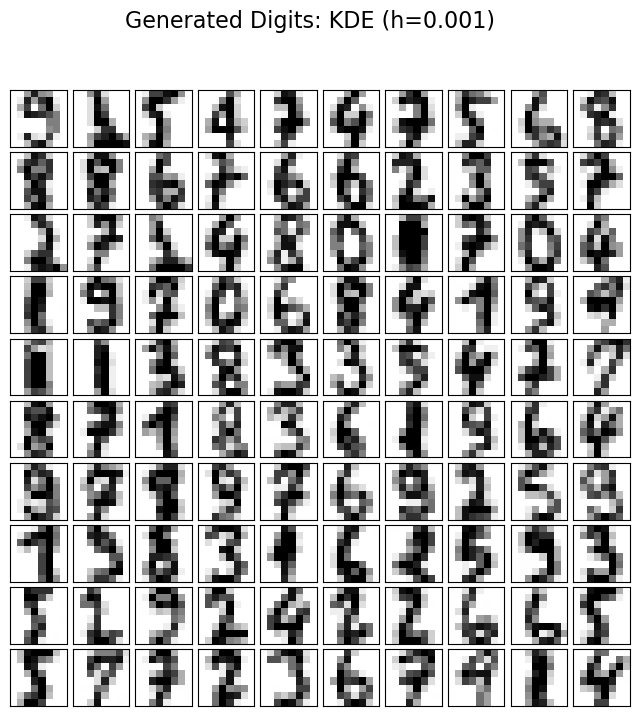

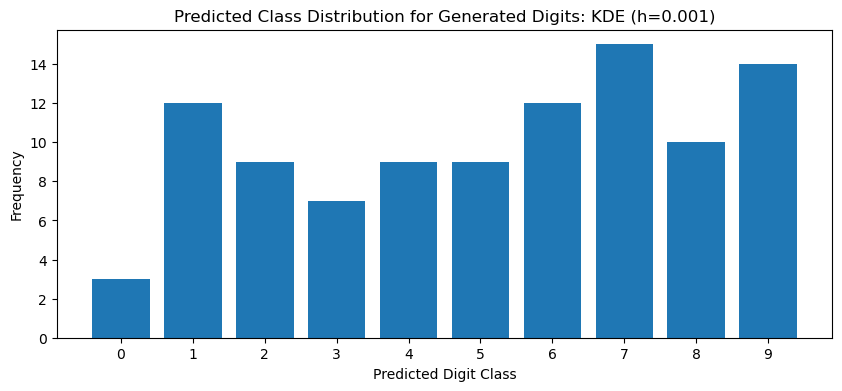

In [146]:
model_kde_64d = KernelDensity(bandwidth=0.001)
model_kde_64d.fit(X_train)
plot_generated_digits_and_classify(model_kde_64d, classifier, title="KDE (h=0.001)")

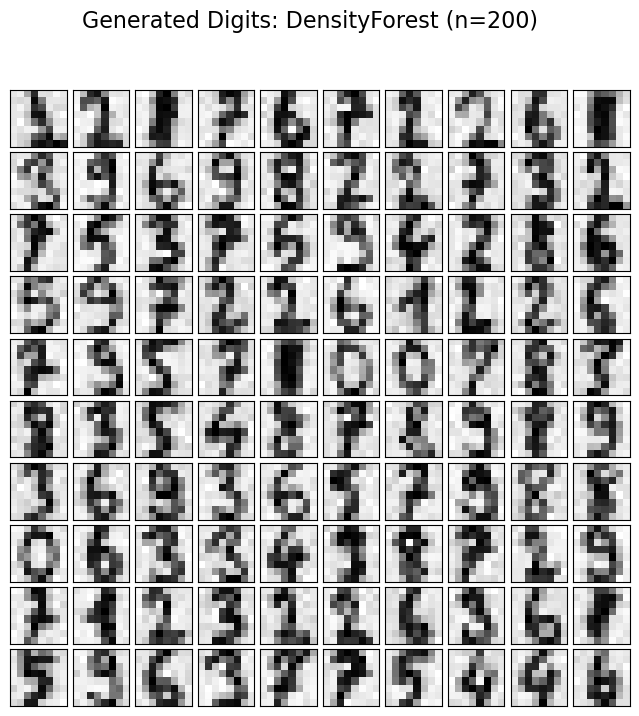

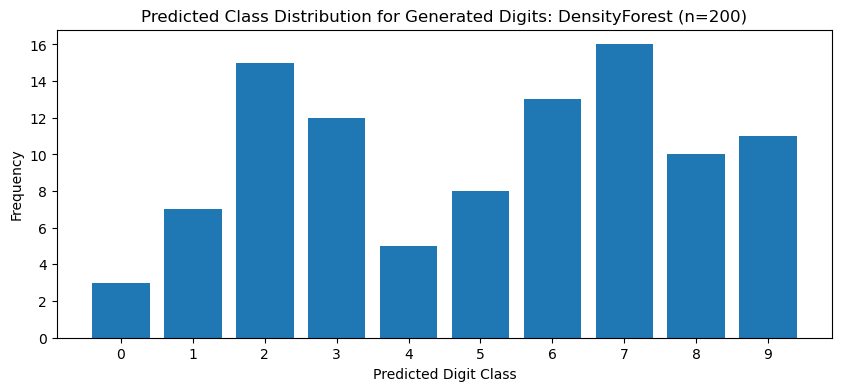

In [150]:
model_forest_64d = DensityForest(n_estimators=200, bandwidth=1.0, random_state=42)
model_forest_64d.fit(X_train)
plot_generated_digits_and_classify(model_forest_64d, classifier, title="DensityForest (n=200)")

By intuition, **KDE** seems to have better results among all others with the selected hyperparameters!